In [86]:
import time

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.utils as utils

# Model Performance Analysis

## Load Data

In [2]:
# Define the transform for the data. From the fruit dataset spec images should be 320x258.
transform = transforms.Compose(
    [transforms.Resize((320,258)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load fruit dataset
fruit_dataset = datasets.ImageFolder("data/",transform=transform)

#Create Data Loader
val_loader = torch.utils.data.DataLoader(fruit_dataset, shuffle=False, num_workers=2, pin_memory=True, batch_size=256)

print(fruit_dataset)

Dataset ImageFolder
    Number of datapoints: 61084
    Root location: data/
    StandardTransform
Transform: Compose(
               Resize(size=(320, 258), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [3]:
fruit_dataset.classes

['Apple',
 'Banana',
 'Carambola',
 'Guava',
 'Kiwi',
 'Mango',
 'Orange',
 'Peach',
 'Pear',
 'Persimmon',
 'Pitaya',
 'Plum',
 'Pomegranate',
 'Tomatoes',
 'muskmelon']

## Load model

In [4]:
# Construct Model
model = models.resnet18(pretrained=False)
# Load model from pretrained models
model = torch.nn.DataParallel(model).cuda()
checkpoint = torch.load('trained/resnet18_320x258_97p.pt')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

## Run Validation

In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [6]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [7]:
# define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss().cuda()

# switch to evaluate mode
model.eval()

incorrect = []

with torch.no_grad():
    # Initialize meters
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):

        input = input.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(prec1[0], input.size(0))
        top5.update(prec5[0], input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 100 == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                  'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                   i, len(val_loader), batch_time=batch_time, loss=losses,
                   top1=top1, top5=top5))

    print(' * Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))

Test: [0/239]	Time 3.032 (3.032)	Loss 0.8123 (0.8123)	Prec@1 67.578 (67.578)	Prec@5 100.000 (100.000)
Test: [100/239]	Time 1.231 (1.280)	Loss 0.0029 (0.0854)	Prec@1 100.000 (96.798)	Prec@5 100.000 (100.000)
Test: [200/239]	Time 0.664 (1.291)	Loss 0.0062 (0.0604)	Prec@1 99.609 (97.950)	Prec@5 100.000 (99.988)
 * Prec@1 97.507 Prec@5 99.985


In [108]:
out_prob, out_class = output.topk(1, 1, True, True)
bool_mask = out_class[:,-1] != target
incorrect_output = output[bool_mask,:].cpu()
incorrect_input = input[bool_mask,:].cpu()
incorrect_target = target[bool_mask].cpu()
incorrect_class = out_class[bool_mask].cpu()

#Renormalize images
inv_normalize = transforms.Normalize(
    mean=[-1, -1, -1],
    std=[1/0.5, 1/0.5, 1/0.5]
)

## Display some incorrectly classified images

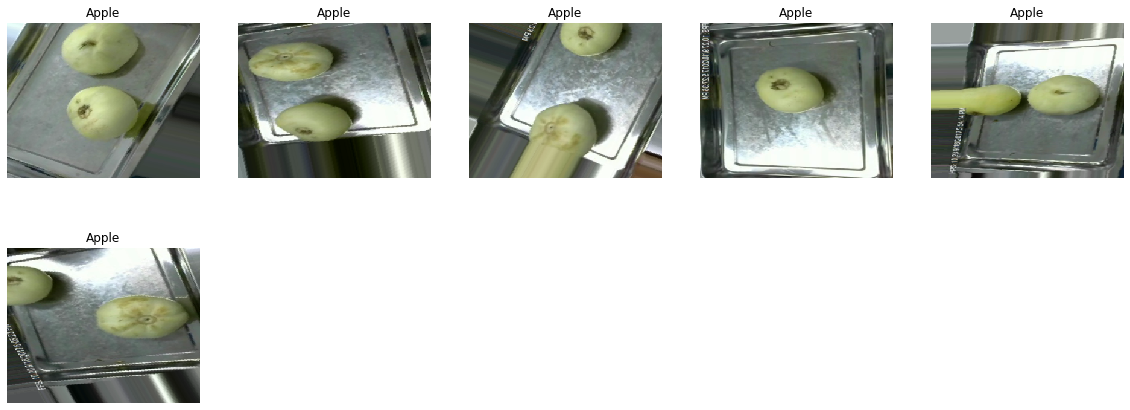

In [119]:
plt.figure(figsize=(20, 20))
for i in range(min(25,len(incorrect_class))):
    plt.subplot(5, 5, i + 1)
    plt.imshow(inv_normalize(incorrect_input[i,:]).T)
    plt.title(fruit_dataset.classes[incorrect_class[i]])
    plt.axis('off');

## Display some images

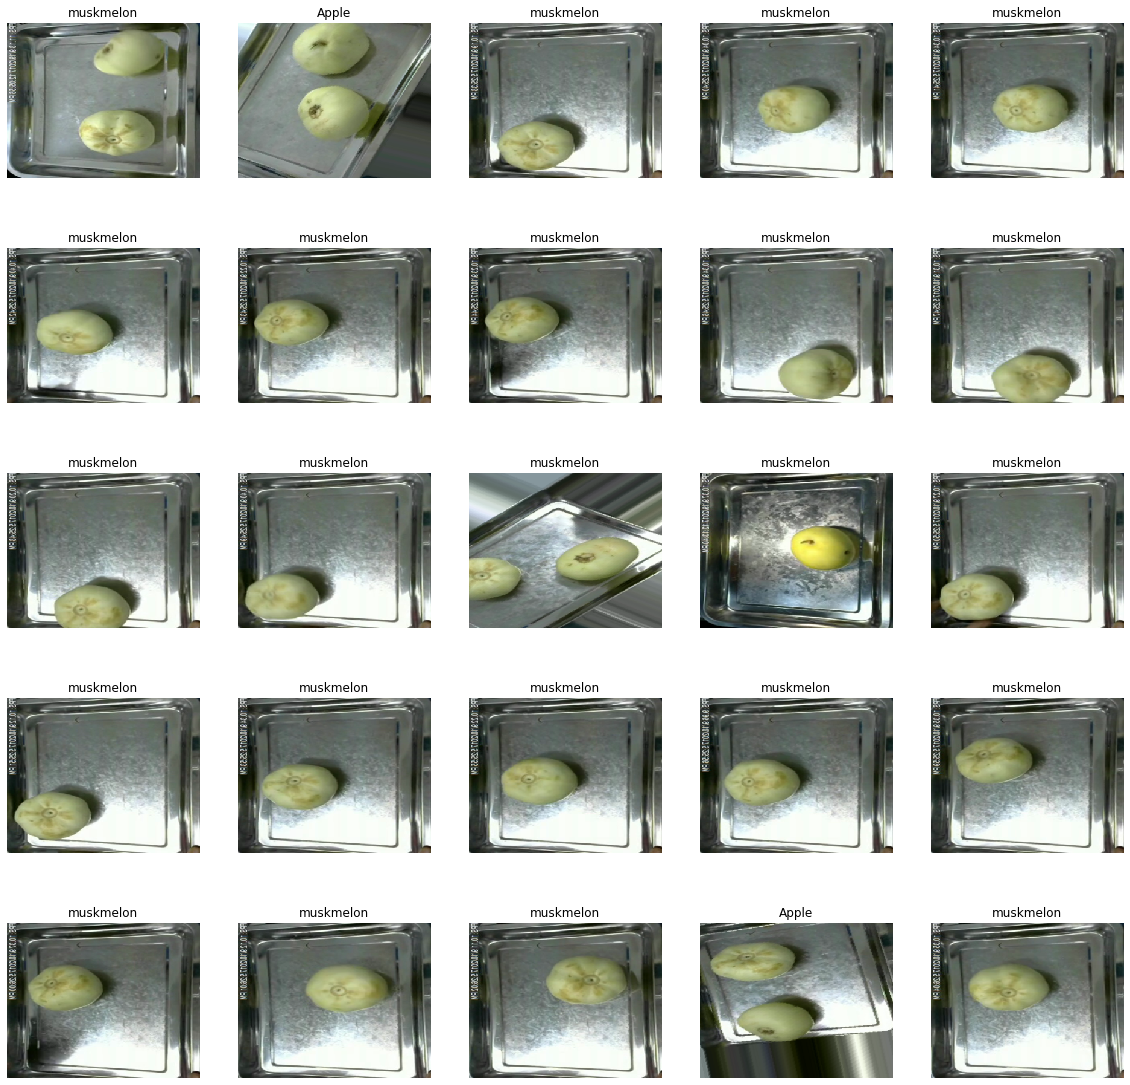

In [121]:
plt.figure(figsize=(20, 20))
for i in range(min(25,len(out_class))):
    plt.subplot(5, 5, i + 1)
    plt.imshow(inv_normalize(input[i,:]).cpu().T)
    plt.title(fruit_dataset.classes[out_class[i]])
    plt.axis('off');